In [4]:
import tensorflow as tf
from tensorflow import keras
import copy
import numpy as np
import pandas as pd

from keras import Model, Sequential, layers
from keras.optimizers import SGD, Adam
from keras.layers import Dense, LSTM, Embedding
from keras.callbacks import LearningRateScheduler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from keras.utils import to_categorical

In [94]:
def normalize(vec):
    max_val = max(vec)
    min_val = min(vec)
    return (vec - min_val) / (max_val - min_val)

def standardize(vec):
    mean = np.mean(vec)
    std = np.std(vec)
    return (vec - mean) / std

def make_equal_bins(bin_count, data):
    labels = []
    for index in range(len(data)):
        for i in range(bin_count):
            if (data.iloc[index]['Cost'] >= 1.0*i/bin_count and data.iloc[index]['Cost'] <= 1.0*(i+1)/bin_count):
                labels.append(i)
    data['Label'] = labels
    return data

def make_custom_bins(bin_values, data):
    labels = []
    for index in range(len(data)):
        for i in range(len(bin_values)):
            if (data.iloc[index]['Cost'] >= bin_values[i] and data.iloc[index]['Cost'] <= bin_values[i+1]):
                labels.append(i)
    data['Label'] = labels
    return data

In [95]:
df = pd.read_csv('data/trace/salman_avg.csv')
bins = 4
MAX_COST = 175
# df = df[df['Cost'] < MAX_COST]
# df['Cost'] = df['Cost'] / MAX_COST
# df['Cost'] = normalize(df['Cost'])
# df = make_equal_bins(bins, df)
df = make_custom_bins([0, 50, 100, 200, 1000], df)
df['Cost'] = normalize(df['Cost'])
df['Long'] = normalize(df['Long'])
df['Lat'] = normalize(df['Lat'])
df['CosTime'] = np.cos(df['TimeMin']/(60*24))
df['SinTime'] = np.sin(df['TimeMin']/(60*24))
feature_cols = ['Long', 'Lat', 'CosTime', 'SinTime', 'Cost']
label_cols = ['Label']

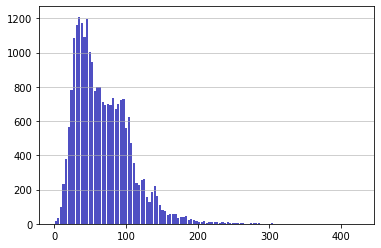

In [91]:
df = pd.read_csv('data/trace/salman_avg.csv')
n, bins, patches = plt.hist(x=df['Cost'], bins='auto', color='#0504aa', alpha=0.7, rwidth=0.85)
plt.grid(axis='y', alpha=0.75)

In [96]:
cat_label = to_categorical(df['Label'])

T = 10
inputrow = []
outputrow = []

for counter in range(0, len(df)-T-1):
    inputrow.append(np.array(df[feature_cols].iloc[counter:counter+T]))
    # outputrow.append(df[label_cols].iloc[counter+T+1])
    outputrow.append(np.array(cat_label[counter+T+1, :]))

inputdf = np.array(inputrow)
outputdf = np.array(outputrow)

# inputdf = df[feature_cols]
# outputdf = df[label_cols]

cutoff = int(0.80*len(inputdf))
X_train = np.float32(inputdf[0:cutoff])
X_test = np.float32(inputdf[cutoff:len(inputdf)])
y_train = np.float32(outputdf[0:cutoff])
y_test = np.float32(outputdf[cutoff:len(outputdf)])

In [98]:
model = Sequential()
model.add(LSTM(100, input_shape=(T, len(feature_cols)), return_sequences=True))
model.add(LSTM(100))
model.add(Dense(100))
model.add(Dense(4, activation='softmax'))
# model.add(Dense(1))

opt = Adam(lr=0.01)
model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=['accuracy'])
model.fit(X_train, y_train, epochs=5, batch_size=100, verbose=True, validation_data=(X_test, y_test))

Epoch 1/5
196/196 [==============================] - 18s 71ms/step - loss: 0.9065 - accuracy: 0.5875 - val_loss: 0.6975 - val_accuracy: 0.7111
Epoch 2/5
196/196 [==============================] - 14s 71ms/step - loss: 0.6638 - accuracy: 0.7206 - val_loss: 0.7280 - val_accuracy: 0.7058
Epoch 3/5
196/196 [==============================] - 14s 74ms/step - loss: 0.6617 - accuracy: 0.7199 - val_loss: 0.7043 - val_accuracy: 0.6964
Epoch 4/5
196/196 [==============================] - 15s 79ms/step - loss: 0.6490 - accuracy: 0.7271 - val_loss: 0.7284 - val_accuracy: 0.6712
Epoch 5/5
196/196 [==============================] - 15s 77ms/step - loss: 0.6269 - accuracy: 0.7326 - val_loss: 0.7450 - val_accuracy: 0.6135


In [108]:
import sklearn
y_pred = model.predict(X_test)
matrix = sklearn.metrics.confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1))
matrix

array([[1293,  531,   12,    0],
       [ 470, 1487,   53,    2],
       [  47,  751,  218,    0],
       [   6,    9,    8,    1]], dtype=int64)

In [111]:
label = y_test.argmax(axis=1)
len(label[label == 3])

24

In [13]:
pred = model.predict(X_test)
rel_mae = np.abs((pred-y_test)/y_test)
print(pred[0:5])
print(y_test[0:5])
print(np.mean(rel_mae))

[[0.41950402]
 [0.37747228]
 [0.39853534]
 [0.4903045 ]
 [0.52805066]]
[[0.53388   ]
 [0.8423431 ]
 [0.5623507 ]
 [0.24121839]
 [0.38785598]]
0.39478767
